In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
%%time

tweets_df = pd.read_json('../input/iphone-12-tweets-fr.json', lines=True)
tweets_df.head(3)

CPU times: user 2.33 s, sys: 422 ms, total: 2.75 s
Wall time: 6.34 s


,url,date,content,renderedContent,id,user,outlinks,tcooutlinks,replyCount,retweetCount,...,quoteCount,conversationId,lang,source,sourceUrl,sourceLabel,media,retweetedTweet,quotedTweet,mentionedUsers
0,https://twitter.com/Poizon__/status/1371062637...,2021-03-14 11:36:20+00:00,La batterie de l’iphone 12 est de qualité 🤌🏾,La batterie de l’iphone 12 est de qualité 🤌🏾,1371062637224677381,"{'username': 'Poizon__', 'displayname': 'Luffy...",[],[],0,0,...,0,1371062637224677381,fr,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,None,NaN,None,None
1,https://twitter.com/OffEditx/status/1371058048...,2021-03-14 11:18:06+00:00,A toi de choisir ton mois d'Avril:\nLike: Sort...,A toi de choisir ton mois d'Avril:\nLike: Sort...,1371058048622530560,"{'username': 'OffEditx', 'displayname': 'Editx...",[],[],0,0,...,0,1371058048622530560,fr,"<a href=""http://twitter.com/download/android"" ...",http://twitter.com/download/android,Twitter for Android,None,NaN,None,None
2,https://twitter.com/amirfj_92/status/137105653...,2021-03-14 11:12:05+00:00,@stee_8 iPhone 12 pro max 256go en noir merci ...,@stee_8 iPhone 12 pro max 256go en noir merci ...,1371056532809523201,"{'username': 'amirfj_92', 'displayname': '🇹🇳 A...",[],[],0,0,...,0,1370762798301593611,fr,"<a href=""http://twitter.com/download/iphone"" r...",http://twitter.com/download/iphone,Twitter for iPhone,None,NaN,None,"[{'username': 'stee_8', 'displayname': '👩🏼‍🦲',..."


## 1. Exploration des données

Dans cette étape je vais explorer les tweets, on peut noter que notre source de données dispose plus de 100 mille tweets, ainsi chaque tweets et caractérisé par 21 colomnes.

In [3]:
tweets_df.shape

(64789, 21)

In [4]:
tweets_df.columns

Index(['url', 'date', 'content', 'renderedContent', 'id', 'user', 'outlinks',
       'tcooutlinks', 'replyCount', 'retweetCount', 'likeCount', 'quoteCount',
       'conversationId', 'lang', 'source', 'sourceUrl', 'sourceLabel', 'media',
       'retweetedTweet', 'quotedTweet', 'mentionedUsers'],
      dtype='object')

Ce qui nous interesse le plus c'est la colomne `content` qui contien le contenu du tweet, donc on peux suprimer toute les autres colmnes, à noter que la colmne `renderedContent` est identique à la colomne `content`.

In [5]:
# garder que les colonnes importantes
cols = ['date', 'content', 'lang']
tweets_df = tweets_df[cols]

In [6]:
# pour etre sur que tout les tweets sont en français
tweets_df = tweets_df[tweets_df['lang'] == 'fr']
tweets_df['lang'].unique()

array(['fr'], dtype=object)

Pour vérifier l'évolution des tweets au fil du temps en utilisant la colomne `date`.

In [7]:
# garder que la date et supprimer l'heure
tweets_df['date'] = pd.to_datetime(tweets_df['date']).dt.date

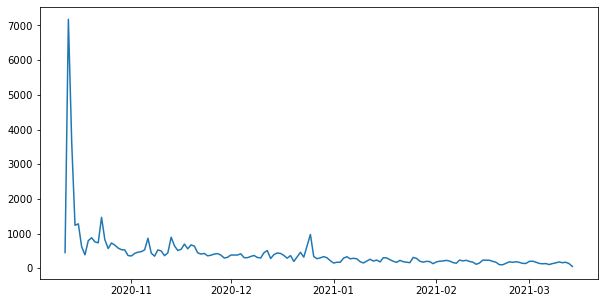

In [8]:
tweets_df['date'].value_counts().plot(kind='line', figsize=(10, 5))

plt.show()

In [9]:
# supprimer les tweets dupliqués, 1K ont été supprimés

tweets_df = tweets_df.sort_values("content") 
  
# dropping ALL duplicte values 
tweets_df = tweets_df.drop_duplicates(subset ="content", keep = 'first')

## 2. Pré-traitement des tweets
Maintenant, après avoir préparé les tweets, nous pouvons commencer la phase de prétraitement afin de pouvoir nettoyer les tweets spécifiquement pour la phase d'identification du sujet. 

In [16]:
# selectionner que les tweets qui répondent au requetes de l'utilisateur

data = tweets_df['content']

keywords = ['stockage', 'écran', 'ecran', 'autonomie', 'réseau', 'reseau', 'alimentation',
           'appareil', 'appareil photo', 'processeur', 'multimédia', 'multimedia', 'résolution', 'resolution',
           'batterie', 'os', 'pièces', 'pieces' , 'couleur',
           'communication', 'sans fil', 'synchronisation', 'coloris', 'poids', 'système', 'systeme',
           'dimensions']

data = data[data.str.contains('|'.join(keywords), case=False)]

In [18]:
ads_words = [
    '#concours', '#jeuconcours', '#giveaway',
    '#gagne' ,'#gangner', '#promo', '#promotion', '#publicité',
    '#contest', '#ad', '#pub', '#réduction', '#vote', 'votez', 'vote']

data = data[~data.str.contains('|'.join(ads_words), case=False)]

In [19]:
len(data)

11830

### 2.1 Importer les packages
Les paquets de base utilisés dans ce tutoriel sont `re`, `gensim`, `spacy` et `pyLDAvis`. En outre, nous utiliserons également `matplotlib`, `numpy` et `pandas` pour le traitement et la visualisation des données qui sont déja importés. 

pour le model du spacy dédié à la langue française, exectutez cette commande sur votre terminal conda:  
`python -m spacy download fr_core_news_sm`  

pour importer le model: `spacy.load('fr_core_news_sm')`

In [20]:
import re
import spacy
from gensim.utils import tokenize

import json

from io import StringIO
from html.parser import HTMLParser

from collections import Counter 

# pour supprimer les emojis
# ce package est capable de remplacer les emojis avec leur signification en text BEAST!!!
#import demoji
#demoji.download_codes()

In [21]:
# fonction pour supprimer les symbols HTML

class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.text = StringIO()
    def handle_data(self, d):
        self.text.write(d)
    def get_data(self):
        return self.text.getvalue()

def strip_tags(html):
    '''
    input, output: string
    '''
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [22]:
# remplacement des abréviations

with open('../input/abrivot_fr.json', encoding='utf-8') as f:
    abrivot = json.load(f)
    
def replace_abrivot(text):
    '''
    input: string
    output: list of tokens
    '''
    words = text.split()
    text_out = [abrivot[word] if word in abrivot else word for word in words]
    return ' '.join(text_out)

In [23]:
# lemmatization fonction
# supprimer les chiffres, les 

# si ça marche pas
nlp = spacy.load('fr_core_news_sm', disable=['parser', 'ner'])


def lemmatization(text, allowed_postags=['NOUN', 'ADJ', 'ADV']):
    '''
    input: string
    output: list of tokens
    '''
    doc = nlp(text) 
    text_out = [token.lemma_ for token in doc if token.pos_ in allowed_postags and token.is_alpha]
    return text_out

In [24]:
# fonction générale pour le prétraitement

def tweets_preprocesser(tweets):
    all_tweets=[]
    for tweet in tweets:
        
        # supprimer les symboles HTML
        reformed = strip_tags(tweet)
        
        # supprimer les urls et les @mentions
        reformed = re.sub(r'(?:\@|https?\://)\S+', '', reformed)
        
        # remplacer les abréviations
        reformed = replace_abrivot(reformed)
        
        # lemmatization
        tokens = lemmatization(reformed)
        
        #tweet_cleaned = " ".join(tokens)
        #all_tweets.append(tweet_cleaned)
        all_tweets.append(tokens)
    #all_text = ' '.join(all_tweets)
    #all_words = ' '.join(all_tweets)
    return all_tweets#, all_words

In [25]:
%%time

all_tweets = tweets_preprocesser(data)
all_tweets[:1]

CPU times: user 44.3 s, sys: 39.3 ms, total: 44.4 s
Wall time: 44.4 s


[['désaccord', 'poto', 'votez', 'plus', 'bel', 'couleur', 'iphone', 'max']]

In [26]:
all_text = ' '.join([' '.join(sent) for sent in all_tweets])
all_words = all_text.split()

In [27]:
# préparer la liste des mots vide, 626 mots
# importer les mots vides de la langue Française

stop_words = nlp.Defaults.stop_words

# fonction pour séléctionner les n mots le plus pertinants
# pour les rajouter dans la liste des mots vides

def select_top_words(bag_words, n_words=30):
    
    # Count all the words using Counter Method
    count_words = Counter(all_words)
    total_words=len(all_words)
    sorted_words=count_words.most_common(total_words)
    
    # select the n_words top words
    top_words = [word[0] for word in sorted_words[:n_words]]
    return top_words

# mettre à jour la liste des mots vides avec les 30 mots les plus fréquents
stop_words.update(select_top_words(all_words))

# mettre à jour la liste d'aprés le fichies des mots vides
with open('../input/fr_stopwords.txt', encoding='utf-8') as f:
    fr_stopwords = f.read().splitlines()
stop_words.update(fr_stopwords)

In [28]:
# supprimer les mots vides
def remove_stopwords(texts):
    
    tokens = [[word for word in doc if word not in stop_words] for doc in texts]
    all_tweets = [doc for doc in tokens if len(doc) > 0] # empthy list not allowed
    
    return all_tweets

all_tweets = remove_stopwords(all_tweets)

## Create the Dictionary and Corpus needed for Topic Modeling

In [29]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(all_tweets)

# Create Corpus
texts = all_tweets

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1)]]


## Building the Topic Model

In [66]:
import gensim

# # Build LDA model
# lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
#                                            id2word=id2word,
#                                            num_topics=14, 
#                                            random_state=100,
#                                            update_every=1,
#                                            chunksize=100,
#                                            passes=10,
#                                            alpha='auto',
#                                            per_word_topics=True)


lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                       id2word=id2word,
                       num_topics=40,
                       random_state=42,
                       chunksize=2000,
                       passes=25,
                       decay=0.5,
                       iterations=70)



/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## View the topics in LDA model

In [67]:
from pprint import pprint

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(30,
  '0.057*"argent" + 0.047*"demain" + 0.036*"pièce" + 0.027*"stock" + '
  '0.025*"nouveauté" + 0.015*"léger" + 0.013*"train" + 0.013*"lot" + '
  '0.012*"gauche" + 0.012*"vendredi"'),
 (32,
  '0.157*"igeneration" + 0.032*"bouygue" + 0.030*"hier" + 0.018*"tactile" + '
  '0.018*"internet" + 0.016*"opérateur" + 0.012*"inférieur" + 0.012*"bug" + '
  '0.011*"terrible" + 0.010*"nécessite"'),
 (3,
  '0.186*"test" + 0.058*"t" + 0.029*"journée" + 0.029*"moyen" + 0.019*"boss" + '
  '0.016*"flou" + 0.014*"oneplu" + 0.014*"connexion" + 0.013*"vie" + '
  '0.010*"vraie"'),
 (10,
  '0.097*"mal" + 0.090*"go" + 0.028*"minute" + 0.024*"pote" + 0.014*"exemple" '
  '+ 0.013*"tranche" + 0.013*"produit" + 0.013*"frais" + 0.013*"paiement" + '
  '0.011*"logo"'),
 (15,
  '0.055*"avis" + 0.050*"gosse" + 0.031*"matin" + 0.026*"youtube" + '
  '0.024*"riche" + 0.024*"an" + 0.020*"simple" + 0.018*"tech" + 0.016*"lidar" '
  '+ 0.015*"parent"'),
 (24,
  '0.092*"appleevent" + 0.061*"gamme" + 0.038*"usb" + 0.035*"h

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Compute Model Perplexity and Coherence Score

In [68]:
from gensim.models import CoherenceModel

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=all_tweets, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Perplexity:  -8.861577879649904

Coherence Score:  0.541561722193193


## Visualize the topics-keywords

In [69]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
22    -0.235333  0.069090       1        1  3.381563
18    -0.010655 -0.077011       2        1  3.270788
23     0.094974 -0.028161       3        1  3.049959
7      0.068121 -0.014040       4        1  3.023066
38    -0.057816 -0.246454       5        1  2.989002
24    -0.108373  0.040496       6        1  2.987263
6     -0.026427  0.012953       7        1  2.933953
26    -0.100854 -0.036849       8        1  2.847565
25     0.088988 -0.050063       9        1  2.789644
2     -0.023080 -0.134033      10        1  2.765900
27    -0.010312 -0.044653      11        1  2.749212
19    -0.098005  0.129383      12        1  2.728726
37    -0.016950 -0.003477      13        1  2.632133
5      0.059737  0.002816      14        1  2.578369
14    -0.159466 -0.045723      15        1  2.565332
0      0.080140 -0.033678      16        1  2.561101
29     0.012188  0.008165      17        1  2.511105
30    -0.023008 -0.059347      18        1  2.509807
1      0.052304  0.061296      19        1  2.485869
21    -0.004108 -0.078279      20        1  2.462492
31    -0.033492 -0.066755      21        1  2.437421
35    -0.077939  0.154401      22        1  2.420665
9     -0.008653  0.138564      23        1  2.400251
13     0.062832 -0.019349      24        1  2.350872
16     0.086271  0.013843      25        1  2.350291
11    -0.009086  0.029840      26        1  2.334243
3      0.082240 -0.002315      27        1  2.310227
33     0.057748  0.001126      28        1  2.263217
34     0.070409  0.053269      29        1  2.255022
8     -0.111788 -0.061388      30        1  2.237752
10     0.020224  0.076637      31        1  2.236061
36    -0.020594  0.026244      32        1  2.226663
39     0.100940  0.067651      33        1  2.222519
12     0.076253  0.062770      34        1  2.221025
32     0.007103  0.056234      35        1  2.162105
15     0.072822 -0.069608      36        1  2.082739
20     0.064880 -0.013240      37        1  1.984150
4     -0.001113  0.057574      38        1  1.958989
17    -0.072699 -0.017992      39        1  1.920877
28     0.051579  0.040063      40        1  1.802062, topic_info=            Term        Freq       Total Category  logprob  loglift
765      support  308.000000  308.000000  Default  30.0000  30.0000
18          jour  321.000000  321.000000  Default  29.0000  29.0000
279     meilleur  310.000000  310.000000  Default  28.0000  28.0000
4321        etui  278.000000  278.000000  Default  27.0000  27.0000
811    sélection  275.000000  275.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
1564     demande    3.967048   21.676887  Topic40  -5.3894   2.3180
371   profondeur    3.323942    9.758568  Topic40  -5.5663   2.9392
152         site    4.177162   88.962545  Topic40  -5.3378   0.9577
2910  conseiller    3.011116    5.379305  Topic40  -5.6651   3.4360
1669        smic    3.032060    9.747213  Topic40  -5.6582   2.8485

[1972 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
865       2  0.071417  abonnement
865      12  0.071417  abonnement
865      21  0.714173  abonnement
865      33  0.071417  abonnement
1786     32  0.815138     abonnez
...     ...       ...         ...
5649     31  0.740255       évoqu
4009     12  0.174505         ête
4009     26  0.698020         ête
2269     34  0.643654         île
4444     18  0.873112         œil

[4303 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[23, 19, 24, 8, 39, 25, 7, 27, 26, 3, 28, 20, 38, 6, 15, 1, 30, 31, 2, 22, 32, 36, 10, 14, 17, 12, 4, 34, 35, 9, 11, 37, 40, 13, 33, 16, 21, 5, 18, 29])

## Building LDA Mallet Model

In [54]:
# # Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# mallet_path = '../packages/mallet-2.0.8/bin/mallet' # update this path
# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [55]:
# # Show Topics
# pprint(ldamallet.show_topics(formatted=False))

# # Compute Coherence Score
# coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=all_tweets, dictionary=id2word, coherence='c_v')
# coherence_ldamallet = coherence_model_ldamallet.get_coherence()
# print('\nCoherence Score: ', coherence_ldamallet)

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## How to find the optimal number of topics for LDA?

In [60]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [61]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=all_tweets, start=7, limit=70, step=3)

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


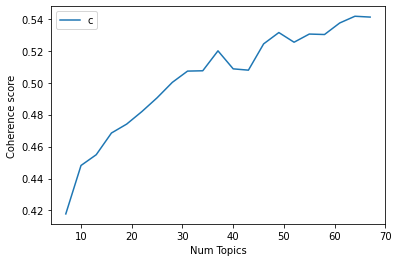

In [63]:
# Show graph
start=7; limit=70; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [64]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 7  has Coherence Value of 0.4179
Num Topics = 10  has Coherence Value of 0.4482
Num Topics = 13  has Coherence Value of 0.4549
Num Topics = 16  has Coherence Value of 0.4685
Num Topics = 19  has Coherence Value of 0.4741
Num Topics = 22  has Coherence Value of 0.4819
Num Topics = 25  has Coherence Value of 0.4905
Num Topics = 28  has Coherence Value of 0.5002
Num Topics = 31  has Coherence Value of 0.5073
Num Topics = 34  has Coherence Value of 0.5075
Num Topics = 37  has Coherence Value of 0.5199
Num Topics = 40  has Coherence Value of 0.5087
Num Topics = 43  has Coherence Value of 0.5078
Num Topics = 46  has Coherence Value of 0.5243
Num Topics = 49  has Coherence Value of 0.5314
Num Topics = 52  has Coherence Value of 0.5253
Num Topics = 55  has Coherence Value of 0.5304
Num Topics = 58  has Coherence Value of 0.5302
Num Topics = 61  has Coherence Value of 0.5374
Num Topics = 64  has Coherence Value of 0.5416
Num Topics = 67  has Coherence Value of 0.5411


/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [65]:
# Select the model and print the topics
optimal_model = model_list[11]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(35,
  '0.129*"oled" + 0.126*"samsung" + 0.056*"réparation" + 0.041*"presque" + '
  '0.040*"officiel" + 0.036*"coûte" + 0.027*"accord" + 0.025*"xr" + '
  '0.020*"remplacement" + 0.020*"ecran"'),
 (20,
  '0.150*"mois" + 0.085*"écouteur" + 0.064*"boîte" + 0.063*"vente" + '
  '0.043*"fond" + 0.038*"code" + 0.029*"million" + 0.023*"décembre" + '
  '0.019*"long" + 0.016*"pays"'),
 (12,
  '0.080*"caméra" + 0.075*"puce" + 0.074*"processeur" + 0.067*"smartphone" + '
  '0.033*"fonction" + 0.032*"détail" + 0.031*"puissant" + 0.030*"propre" + '
  '0.028*"différence" + 0.023*"outil"'),
 (9,
  '0.174*"disponible" + 0.086*"précommande" + 0.081*"site" + 0.061*"octobre" + '
  '0.048*"boutique" + 0.040*"novembre" + 0.039*"commande" + 0.039*"stock" + '
  '0.036*"magasin" + 0.032*"livraison"'),
 (19,
  '0.100*"info" + 0.057*"offre" + 0.048*"avis" + 0.047*"keynote" + '
  '0.040*"jaune" + 0.035*"tech" + 0.031*"actuellement" + 0.031*"actualité" + '
  '0.029*"fuite" + 0.027*"impression"'),
 (21,
  '0.237*"g

/anaconda/envs/pfe-env/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
